In [7]:
import pandas as pd
import datetime as date
import time
import numpy as np
import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from numpy import array
from keras.models import load_model

# Funções

In [8]:
def avaliacao(df_aux, col_pred, col_real):    
    df = df_aux.copy()
    df['PE'] = abs(df[col_pred]-df[col_real])/df[col_real]
    df['AE'] = abs(df[col_pred]-df[col_real])
    df['SE'] = (df[col_pred]-df[col_real])*(df[col_pred]-df[col_real])
    mae = df['AE'].mean()
    mape = df['PE'].mean()
    rmse = sqrt(float(df['SE'].mean()))
    #print('MAE: ',mae)
    #print('MAPE: ',mape)
    #print('RMSE: ',rmse)
    return mae, mape, rmse, df

In [9]:
def inverse_MinMax(df, df_inverse, col_pred, col_inverse):
    df_aux = df.copy()
    df_aux[col_pred] = (df_aux[col_pred]*df_inverse[col_inverse][1])+df_inverse[col_inverse][0]
    return df_aux

In [10]:
def pred_for_inverse(pred, X, Y):
    array_aux = [[0]]*Y.shape[1]
    c=0
    for i in pred[0]:
        a = [0]*X.shape[2]
        a[0] = i
        array_aux[c] = a
        c+=1
    return array_aux

In [11]:
def teste_modelo_3feat (modelo, TrainX, TrainY, TestX, TestY, scaler_used, df_original):
    dict_global = {} 
    for i in range(0,testX.shape[0]):
        x_input = array(TestX[i].reshape((1, TestX.shape[1], TestX.shape[2])))
        prediction = modelo.predict(x_input, verbose=0)
        predction_for_inv = pred_for_inverse(prediction, TrainX, TrainY)
        Pred_inversed = scaler_used.inverse_transform(predction_for_inv)
        pred_inverse = pd.DataFrame()
        pred_inverse = pd.DataFrame(Pred_inversed)
        pred_inverse = pred_inverse.rename(columns={0:'PLD - Predito'}).drop(columns={1,2})
        pred_inverse = pred_inverse.set_index(df_original[TestX.shape[1]+i:TestX.shape[1]+TestY.shape[1]+i].index)
        df_comp = pred_inverse.join(df_original['SE - PLD Médio (R$/MWh)'][TestX.shape[1]+i:TestX.shape[1]+TestY.shape[1]+i])
        col_pred, col_real = df_comp.columns[0], df_comp.columns[1]
        aval = avaliacao(df_comp, col_pred, col_real)
        dict_info = {'mae':aval[0], 'mape':aval[1], 'rmse':aval[2]}
        dict_append = {'df':aval[3], 'info':dict_info }
        dict_global[i+1] = dict_append
    return dict_global

In [12]:
def Janelamento_Sem_Saturação(list_df, n_lags, n_steps):
    array_aux_X_final = []
    array_aux_Y_final = []
    for i in list_df:
        array_aux_train_1 = []
        array_aux_test_1 = []
        trainX = []
        trainY = []
        df_for_training_scaled = np.array(i)
        df_for_testing_scaled = np.array(i)
        for i in range(n_lags, len(df_for_training_scaled) - n_steps +1):
            trainX.append(df_for_training_scaled[i - n_lags:i, 0:df_for_training_scaled.shape[1]])
            trainY.append(df_for_training_scaled[i : i + n_steps, 0])
        trainX, trainY = np.array(trainX), np.array(trainY)
        if array_aux_X_final == array_aux_Y_final:
            array_aux_X_final = trainX
            array_aux_Y_final = trainY
        else:
            array_aux_X_final = np.append(array_aux_X_final, trainX, axis=0)
            array_aux_Y_final = np.append(array_aux_Y_final, trainY, axis=0)
    return array_aux_X_final, array_aux_Y_final

________________________________________________________________________________________________________________________

# Leitura dos dados

## PLD

In [13]:
df_final_PLD =  pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\PLD_2018_2021_diario.xlsx')

In [14]:
df_final_PLD_2 = df_final_PLD.copy()
df_final_PLD_2['Data'] = pd.to_datetime(df_final_PLD_2['Data'])
df_final_PLD_2 = df_final_PLD_2.set_index('Data')

________________________________________________________________________________________________________________________

## ENA por Subsistema

In [15]:
df_final_ENASub = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\ENA_Sub_2018_2021_diario.xlsx', index_col = 'Data')
df_ENA_total = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\ENA_Total_2018_2021_diario.xlsx', index_col = 'Data')

In [16]:
df_ecolhido_ena = df_ENA_total.drop(columns = 'ENA Armaz. (MWm)')


________________________________________________________________________________________________________________________

## EAR por Subsistema

In [17]:
df_final_EARSub = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\EAR_Sub_2018_2021_diario.xlsx', index_col = 'Data')
df_EAR_total = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\EAR_Total_2018_2021_diario.xlsx', index_col = 'Data')

________________________________________________________________________________________________________________________

## Carga diária Energia

In [18]:
df_final_Carga = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\Carga_Sub_2018_2021_diario.xlsx', index_col = 'Data')
df_Carga_total = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\Carga_Total_2018_2021_diario.xlsx', index_col = 'Data')

________________________________________________________________________________________________________________________

# Junção Variáveis

In [20]:
def JoinVar (df1, df2, df3, df4, df5, df6, df7):
    lista = [df2, df3, df4, df5, df6, df7]
    df_final = df1
    for i in lista:
        df_final = df_final.join(i)
    return df_final

In [21]:
def MinMax_Scaler(df):
    df_aux = df.copy()
    df_inverse = pd.DataFrame()
    for i in df.columns:
        df_inverse[i] = [df[i].min(), (df[i].max() - df[i].min())]
        df_aux[i] = (df[i] - df[i].min())/(df[i].max() - df[i].min()) 
    return df_aux, df_inverse

In [22]:
def Inverse_MinMax_Scaler(df, df_inverse):
    df_aux = df.copy()
    for i in df.columns:
        df_aux[i] = (df_aux[i]*df_inverse[i][1])+df_inverse[i][0]
    return df_aux

In [24]:
df_var = JoinVar (df_final_PLD_2, df_final_ENASub, df_final_EARSub, df_final_Carga, df_Carga_total, df_ENA_total, df_EAR_total)


In [25]:
df_corr = df_var.corr()
df_corr.style.background_gradient(cmap='coolwarm')

,SE - PLD Médio (R$/MWh),S - PLD Médio (R$/MWh),NE - PLD Médio (R$/MWh),N - PLD Médio (R$/MWh),SE - ENA Bruta (MWm),SE - ENA Bruta (%),SE - ENA Bruta Armaz. (MWm),SE - ENA Armaz. (%),S - ENA Bruta (MWm),S - ENA Bruta (%),S - ENA Bruta Armaz. (MWm),S - ENA Armaz. (%),NE - ENA Bruta (MWm),NE - ENA Bruta (%),NE - ENA Bruta Armaz. (MWm),NE - ENA Armaz. (%),N - ENA Bruta (MWm),N - ENA Bruta (%),N - ENA Bruta Armaz. (MWm),N - ENA Armaz. (%),SE - EAR Máx.,SE - EAR Verif. (MWmês),SE - EAR Verif (%),S - EAR Máx.,S - EAR Verif. (MWmês),S - EAR Verif (%),NE - EAR Máx.,NE - EAR Verif. (MWmês),NE - EAR Verif (%),N - EAR Máx.,N - EAR Verif. (MWmês),N - EAR Verif (%),SE - Carga (MWm),S - Carga (MWm),NE - Carga (MWm),N - Carga (MWm),Carga (MWm),Media Móvel 7,ENA Bruta (MWm),ENA Armaz. (MWm),EAR Máx.,EAR Verif. (MWmês),EAR Verif. Total (%)
SE - PLD Médio (R$/MWh),1.000000,0.994705,0.909312,0.884002,-0.456428,-0.491654,-0.464533,-0.455538,-0.059174,-0.114586,-0.041597,-0.101654,-0.500729,-0.530166,-0.501979,-0.541761,-0.479774,-0.432363,-0.478584,-0.329629,-0.029409,-0.449146,-0.447201,-0.289713,-0.180718,-0.173470,0.165258,-0.442120,-0.447985,0.076971,-0.096069,-0.098508,0.121529,0.082629,0.194463,0.225818,0.137828,0.112206,-0.519506,-0.512795,-0.001605,-0.462456,-0.461686
S - PLD Médio (R$/MWh),0.994705,1.000000,0.904744,0.878021,-0.430855,-0.480984,-0.439090,-0.447259,-0.073684,-0.128961,-0.057313,-0.117043,-0.470710,-0.513586,-0.471630,-0.524715,-0.454323,-0.425578,-0.454286,-0.330139,-0.026933,-0.437859,-0.435999,-0.280746,-0.201202,-0.193973,0.161269,-0.433345,-0.439084,0.071452,-0.091458,-0.093843,0.131827,0.098106,0.198766,0.221881,0.148357,0.125605,-0.494213,-0.488340,-0.000326,-0.453898,-0.453173
NE - PLD Médio (R$/MWh),0.909312,0.904744,1.000000,0.904331,-0.446987,-0.389409,-0.442921,-0.334980,-0.010383,-0.082901,0.008350,-0.071058,-0.477974,-0.494069,-0.479859,-0.506747,-0.513141,-0.422301,-0.521066,-0.320421,0.031212,-0.440932,-0.439546,-0.273832,-0.125596,-0.119064,0.213875,-0.449425,-0.456487,0.136314,-0.059133,-0.061980,0.072301,0.038958,0.199103,0.239989,0.098127,0.065714,-0.511988,-0.497719,0.059536,-0.449012,-0.448995
N - PLD Médio (R$/MWh),0.884002,0.878021,0.904331,1.000000,-0.578325,-0.445260,-0.567771,-0.372311,-0.063593,-0.165849,-0.056603,-0.167840,-0.507864,-0.393938,-0.511248,-0.407100,-0.614781,-0.383116,-0.634752,-0.260287,0.110757,-0.456550,-0.455916,-0.207597,-0.154471,-0.149019,0.221227,-0.393223,-0.400198,0.148828,-0.074835,-0.077828,0.020138,0.008442,0.137309,0.273484,0.051660,0.004417,-0.642517,-0.627355,0.123416,-0.449669,-0.450455
SE - ENA Bruta (MWm),-0.456428,-0.430855,-0.446987,-0.578325,1.000000,0.545385,0.996080,0.445929,-0.041514,0.129469,-0.036907,0.151537,0.827614,0.379964,0.834219,0.389409,0.719921,0.182807,0.790982,0.072333,-0.015887,0.085437,0.085042,0.083652,-0.169024,-0.167653,-0.082695,0.041745,0.043551,-0.048080,-0.243900,-0.243389,0.225822,0.277389,0.164607,-0.280284,0.213207,0.306996,0.960672,0.975901,-0.028753,0.028385,0.028477
SE - ENA Bruta (%),-0.491654,-0.480984,-0.389409,-0.445260,0.545385,1.000000,0.563227,0.985026,0.223128,0.212427,0.216540,0.203224,0.367431,0.463248,0.364735,0.459035,0.236147,0.334338,0.263015,0.312438,-0.278758,0.154029,0.156349,-0.058174,0.205912,0.208398,-0.278644,-0.139934,-0.132083,-0.215637,-0.100238,-0.097266,-0.140486,-0.041888,-0.043788,-0.296624,-0.123014,-0.166852,0.511125,0.531945,-0.295680,0.082649,0.086538
SE - ENA Bruta Armaz. (MWm),-0.464533,-0.439090,-0.442921,-0.567771,0.996080,0.563227,1.000000,0.475985,-0.030418,0.137768,-0.024186,0.160785,0.822780,0.388107,0.829853,0.398334,0.687344,0.174775,0.762699,0.076583,-0.010810,0.068965,0.068597,0.085495,-0.169470,-0.168041,-0.088607,0.025838,0.027866,-0.049880,-0.270550,-0.270018,0.227797,0.285328,0.171368,-0.279114,0.217398,0.300525,0.949056,0.972470,-0.027487,0.009815,0.009959
SE - ENA Armaz. (%),-0.455538,-0.447259,-0.334980,-0.372311,0.445929,0.985026,0.475985,1.000000,0.247359,0.214034,0.245548,0.2

________________________________________________________________________________________________________________________

# Escolha Variáveis

In [26]:
sel = ['S - PLD Médio (R$/MWh)', 'NE - PLD Médio (R$/MWh)',
       'N - PLD Médio (R$/MWh)','SE - ENA Bruta (%)','SE - ENA Armaz. (%)','SE - EAR Verif (%)',
     'Carga (MWm)','Media Móvel 7', 'ENA Bruta (MWm)','ENA Armaz. (MWm)','EAR Verif. Total (%)']
df_escolhido = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel:
    df_escolhido = df_escolhido.join(df_var[i])
df_escolhido

,SE - PLD Médio (R$/MWh),S - PLD Médio (R$/MWh),NE - PLD Médio (R$/MWh),N - PLD Médio (R$/MWh),SE - ENA Bruta (%),SE - ENA Armaz. (%),SE - EAR Verif (%),Carga (MWm),Media Móvel 7,ENA Bruta (MWm),ENA Armaz. (MWm),EAR Verif. Total (%)
Data,,,,,,,,,,,,
2018-05-02,214.646667,214.662500,190.621250,178.925000,88.275002,76.983398,43.900200,65381.392583,62470.348417,58970.907959,49664.467773,0.458910
2018-05-03,168.905833,168.934167,120.433333,120.406667,86.215599,78.004204,43.828999,66938.248333,62346.022095,57479.126953,49444.537354,0.457995
2018-05-04,225.345833,225.367500,114.855000,114.823333,84.744102,77.204201,43.728298,67031.116625,62219.178869,56654.833008,48306.832764,0.456794
2018-05-05,275.532500,275.570833,123.934583,123.894583,83.725899,75.946098,43.696999,61356.033375,62134.300214,55804.570068,46507.023682,0.456325
2018-05-06,155.334583,155.357917,77.849167,77.827500,82.473701,71.800201,43.691299,55092.441625,62080.463613,54926.362549,44621.667969,0.456129
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,68.084167,68.085000,68.037917,68.037083,110.278900,96.091698,24.684700,69066.145500,66970.400155,90544.118652,79667.989746,0.314215
2021-12-28,68.389167,68.389167,68.353333,68.352500,110.417297,96.244102,24.862000,69954.770708,66429.492506,91952.735107,80709.130127,0.317530
2021-12-29,66.705417,66.705417,66.067500,65.970833,111.535103,96.548798,25.012400,69973.731792,65782.750810,94431.855835,82476.878052,0.320648


In [27]:
sel_2 = ['ENA Bruta (MWm)','EAR Verif. (MWmês)','Carga (MWm)']
df_4_features = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel_2:
    df_4_features = df_4_features.join(df_var[i])
df_4_features

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Carga (MWm)
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,65381.392583
2018-05-03,168.905833,57479.126953,132303.383789,66938.248333
2018-05-04,225.345833,56654.833008,131956.226563,67031.116625
2018-05-05,275.532500,55804.570068,131820.939453,61356.033375
2018-05-06,155.334583,54926.362549,131764.245117,55092.441625
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,69066.145500
2021-12-28,68.389167,91952.735107,92468.512207,69954.770708
2021-12-29,66.705417,94431.855835,93376.443359,69973.731792


In [28]:
df_escolhido_2 = df_4_features
df_escolhido_2

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Carga (MWm)
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,65381.392583
2018-05-03,168.905833,57479.126953,132303.383789,66938.248333
2018-05-04,225.345833,56654.833008,131956.226563,67031.116625
2018-05-05,275.532500,55804.570068,131820.939453,61356.033375
2018-05-06,155.334583,54926.362549,131764.245117,55092.441625
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,69066.145500
2021-12-28,68.389167,91952.735107,92468.512207,69954.770708
2021-12-29,66.705417,94431.855835,93376.443359,69973.731792


In [29]:
sel_3 = ['ENA Bruta (MWm)','EAR Verif. (MWmês)']
df_3_features = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel_3:
    df_3_features = df_3_features.join(df_var[i])
df_3_features

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês)
Data,,,
2018-05-02,214.646667,58970.907959,132567.533203
2018-05-03,168.905833,57479.126953,132303.383789
2018-05-04,225.345833,56654.833008,131956.226563
2018-05-05,275.532500,55804.570068,131820.939453
2018-05-06,155.334583,54926.362549,131764.245117
...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000
2021-12-28,68.389167,91952.735107,92468.512207
2021-12-29,66.705417,94431.855835,93376.443359


In [30]:
sel_4 = ['ENA Bruta (MWm)','EAR Verif. (MWmês)','Media Móvel 7']
df_4_features_mediacarga = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel_4:
    df_4_features_mediacarga = df_4_features_mediacarga.join(df_var[i])
df_4_features_mediacarga

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Media Móvel 7
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,62470.348417
2018-05-03,168.905833,57479.126953,132303.383789,62346.022095
2018-05-04,225.345833,56654.833008,131956.226563,62219.178869
2018-05-05,275.532500,55804.570068,131820.939453,62134.300214
2018-05-06,155.334583,54926.362549,131764.245117,62080.463613
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,66970.400155
2021-12-28,68.389167,91952.735107,92468.512207,66429.492506
2021-12-29,66.705417,94431.855835,93376.443359,65782.750810


________________________________________________________________________________________________________________________

# Escalas

In [31]:
df_4_features

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Carga (MWm)
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,65381.392583
2018-05-03,168.905833,57479.126953,132303.383789,66938.248333
2018-05-04,225.345833,56654.833008,131956.226563,67031.116625
2018-05-05,275.532500,55804.570068,131820.939453,61356.033375
2018-05-06,155.334583,54926.362549,131764.245117,55092.441625
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,69066.145500
2021-12-28,68.389167,91952.735107,92468.512207,69954.770708
2021-12-29,66.705417,94431.855835,93376.443359,69973.731792


In [32]:
scaler_standard = StandardScaler()
scaler_standard_4_features = scaler_standard.fit(df_4_features)
array_4_features_standard_scale = scaler_standard_4_features.transform(df_4_features)
df_4_features_standard_scale = pd.DataFrame(array_4_features_standard_scale)
df_4_features_standard_scale = df_4_features_standard_scale.rename(columns={0:'SE - PLD Médio (R$/MWh)', 1:'ENA Bruta (MWm)', 2: 'EAR Verif. (MWmês)', 3: 'Carga (MWm)'})
df_4_features_standard_scale = df_4_features_standard_scale.set_index(df_4_features.index)


In [33]:
scaler_minmax = MinMaxScaler()
scaler_MinMax_4_features = scaler_minmax.fit(df_4_features)
array_4_features_MinMax_scale = scaler_MinMax_4_features.transform(df_4_features)
df_4_features_MinMax_scale = pd.DataFrame(array_4_features_MinMax_scale)
df_4_features_MinMax_scale = df_4_features_MinMax_scale.rename(columns={0:'SE - PLD Médio (R$/MWh)', 1:'ENA Bruta (MWm)', 2: 'EAR Verif. (MWmês)', 3: 'Carga (MWm)'})
df_4_features_MinMax_scale = df_4_features_MinMax_scale.set_index(df_4_features.index)


In [35]:
scaler_robust = RobustScaler()
scaler_robust_4_features = scaler_robust.fit(df_4_features)
array_4_features_robust_scale = scaler_robust_4_features.transform(df_4_features)
df_4_features_robust_scale = pd.DataFrame(array_4_features_robust_scale)
df_4_features_robust_scale = df_4_features_robust_scale.rename(columns={0:'SE - PLD Médio (R$/MWh)', 1:'ENA Bruta (MWm)', 2: 'EAR Verif. (MWmês)', 3: 'Carga (MWm)'})
df_4_features_robust_scale = df_4_features_robust_scale.set_index(df_4_features.index)


In [38]:
df_4_features_mediacarga

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Media Móvel 7
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,62470.348417
2018-05-03,168.905833,57479.126953,132303.383789,62346.022095
2018-05-04,225.345833,56654.833008,131956.226563,62219.178869
2018-05-05,275.532500,55804.570068,131820.939453,62134.300214
2018-05-06,155.334583,54926.362549,131764.245117,62080.463613
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,66970.400155
2021-12-28,68.389167,91952.735107,92468.512207,66429.492506
2021-12-29,66.705417,94431.855835,93376.443359,65782.750810


In [37]:
scaler_minmax_mc = MinMaxScaler()
scaler_MinMax_4_features_mc = scaler_minmax_mc.fit(df_4_features_mediacarga)
array_4_features_MinMax_scale_mc = scaler_MinMax_4_features_mc.transform(df_4_features_mediacarga)
df_4_features_MinMax_scale_mc = pd.DataFrame(array_4_features_MinMax_scale_mc)
df_4_features_MinMax_scale_mc = df_4_features_MinMax_scale_mc.rename(columns={0:'SE - PLD Médio (R$/MWh)', 1:'ENA Bruta (MWm)', 2: 'EAR Verif. (MWmês)', 3: 'Media Móvel 7'})
df_4_features_MinMax_scale_mc = df_4_features_MinMax_scale_mc.set_index(df_4_features_mediacarga.index)

___________________________________________________________________________________________________________________________

# MultiStep - 3 passos à frente

In [134]:
iniciotrein, fimtrein, inicioteste, fimteste = '2018-02-05','2021-11-30','2021-12-01','2021-12-31'
df_treinamento = df_3_features.loc[iniciotrein:fimtrein]
df_teste = df_3_features.loc[inicioteste:fimteste]
df_teste_original = df_3_features.loc[inicioteste:fimteste]

df_for_training = df_treinamento
scaler = MinMaxScaler()
scaler_train = scaler.fit(df_for_training)
df_for_training_scaled = scaler_train.transform(df_for_training)
df_comp_trein = pd.DataFrame(df_for_training_scaled)
df_comp_trein = df_comp_trein.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_trein = df_comp_trein.set_index(df_treinamento.index)


In [135]:
df_for_testing = df_teste
df_for_testing_scaled = scaler_train.transform(df_for_testing)
df_comp_teste = pd.DataFrame(df_for_testing_scaled)
df_comp_teste = df_comp_teste.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_teste = df_comp_teste.set_index(df_teste.index)


In [136]:
trainX = []
trainY = []
testX = []
testY = []
n_future = 3
n_past = 14

In [137]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i :i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [138]:
for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing_scaled.shape[1]])
    testY.append(df_for_testing_scaled[i :i + n_future, 0])
    
testX, testY = np.array(testX), np.array(testY)

In [139]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1293, 14, 3).
trainY shape == (1293, 3).
testX shape == (15, 14, 3).
testY shape == (15, 3).


In [140]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(50))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               41600     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 46,803
Trainable params: 46,803
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
4/4 [==============================] - 2s 127ms/step - loss: 0.2264 - val_loss: 0.3547
Epoch 2/50
4/4 [==============================] - 0s 38ms/step - loss: 0.1427 - val_loss: 0.2147
Epoch 3/50
4/4 [==============================] - 0s 40ms/step - loss: 0.0914 - val_loss: 0.1019
Epoch 4/50
4/4 [==============================] - 0s 39ms/step - loss: 0.0648 - val_loss: 0.0492
Epoch 5/50
4/4 [==============================] - 0s 43ms/step - loss: 0.0398 - val_loss: 0.0277
Epoch 6/50
4/4 [==============================] - 0s 37ms/step - loss: 0.0204 - val_loss: 0.0164
Epoch 7/50
4/4 [==============================] - 0s 35ms/step - loss: 0.0125 - val_loss: 0.0194
Epoch 8/50
4/4 [==============================] - 0s 43ms/step - loss: 0.0115 - val_loss: 0.0183
Epoch 9/50
4/4 [==============================] - 0s 33ms/step - loss: 0.0108 - val_loss: 0.0150
Epoch 10/50
4/4 [==============================] - 0s 32ms/step - loss: 0.0091 - val_loss: 0.0124
Epoch 11/50
4/4 [===========

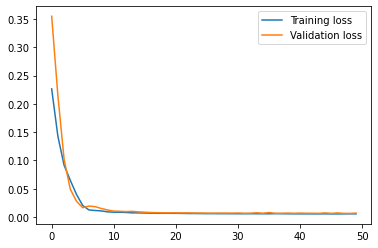

In [141]:
# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=264, validation_split=0.2, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [142]:
model = load_model('Modelos_Multi_Step\model_lstm_multistep_nstep14_nforw3_.h5')

In [143]:
testes_3 = teste_modelo_3feat (model, trainX, trainY, testX, testY, scaler_train, df_teste_original)

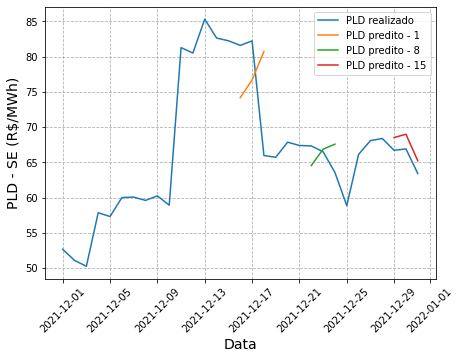

In [144]:
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_3_features['SE - PLD Médio (R$/MWh)']['2021-12-01':], label = 'PLD realizado')
plt.plot(testes_3[1]['df']['PLD - Predito'], label = 'PLD predito - 1')
plt.plot(testes_3[8]['df']['PLD - Predito'], label = 'PLD predito - 8')
plt.plot(testes_3[15]['df']['PLD - Predito'], label = 'PLD predito - 15')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Multi_step\Modelo_3',bbox_inches='tight')

In [145]:
indice = []
mae = []
for i in range (1,testX.shape[0]+1):
    indice.append(i)
    mae.append(testes_3[i]['info']['mae'])
df_mae = pd.DataFrame({'Teste':indice,'MAE':mae})
df_mae['MAE'].mean()

5.0204464488497536

In [146]:
indice = []
mapes = []
for i in range (1,testX.shape[0]+1):
    indice.append(i)
    mapes.append(testes_3[i]['info']['mape'])
df_mape = pd.DataFrame({'Teste':indice,'MAPE':mapes})
df_mape['MAPE'].mean()

0.073748263671926

In [147]:
indice = []
mapes = []
for i in range (1,testX.shape[0]+1):
    indice.append(i)
    mapes.append(testes_3[i]['info']['rmse'])
df_mape = pd.DataFrame({'Teste':indice,'RMSE':mapes})

count = 0
SE = 0
for j in df_mape['RMSE']:
    SE = j*j +SE
    count+=1

print(sqrt(SE/count))

6.306295403722036


## Erro por passo - n3

In [148]:
df_init_3 = testes_3[1]['df'].reset_index()
for i in range(2,len(testes_3)+1):
    df_init_3 =  df_init_3.append(testes_3[i]['df'].reset_index())


In [149]:
df_erros_passos_3 = pd.DataFrame()
df_erros_passos_3['PE Passo 1'] = df_init_3['PE'][0]
df_erros_passos_3['AE Passo 1'] = df_init_3['AE'][0]
df_erros_passos_3['SE Passo 1'] = df_init_3['SE'][0]
df_erros_passos_3 = df_erros_passos_3.reset_index().drop(columns=['index'])
for i in range(1,max(df_init_3.index)+1):
    df_erro = pd.DataFrame()
    df_erro['PE Passo ' + str(i+1)] = df_init_3['PE'][i]
    df_erro['AE Passo ' + str(i+1)] = df_init_3['AE'][i]
    df_erro['SE Passo ' + str(i+1)] = df_init_3['SE'][i]
    df_erro = df_erro.reset_index().drop(columns=['index'])
    df_erros_passos_3 = df_erros_passos_3.join(df_erro)
df_erros_passos_3

,PE Passo 1,AE Passo 1,SE Passo 1,PE Passo 2,AE Passo 2,SE Passo 2,PE Passo 3,AE Passo 3,SE Passo 3
0,0.114910,9.451494,89.330739,0.079946,6.523164,42.551668,0.033404,2.746800,7.544913
1,0.090856,7.413375,54.958130,0.067332,5.536745,30.655550,0.223830,14.766240,218.041830
2,0.090994,7.482491,55.987675,0.172877,11.404822,130.069972,0.232785,15.298643,234.048473
3,0.140808,9.289191,86.289077,0.184382,12.117572,146.835544,0.194116,13.173488,173.540796
4,0.068912,4.528907,20.510996,0.080693,5.476139,29.988098,0.130134,8.770273,76.917680
5,0.014326,0.972219,0.945210,0.038079,2.566285,6.585820,0.071641,4.823814,23.269180
6,0.028775,1.939254,3.760707,0.012153,0.818298,0.669611,0.046750,3.109179,9.666993
7,0.041372,2.785696,7.760102,0.005410,0.359813,0.129465,0.063399,4.029399,16.236055
8,0.034213,2.275432,5.177589,0.041070,2.610228,6.813292,0.123965,7.296688,53.241660
9,0.009697,0.616320,0.379850,0.117608,6.922519,47.921264,0.015684,1.037276,1.075941


In [150]:
indice=[]
mape=[]
mae=[]
rmse=[]
for i in range(1,max(df_init_3.index)+2):
    indice.append(i)
    mape.append(df_erros_passos_3['PE Passo '+str(i)].mean())
    mae.append(df_erros_passos_3['AE Passo '+str(i)].mean())
    rmse.append(sqrt(df_erros_passos_3['SE Passo '+str(i)].mean()))
df_erros_3 = pd.DataFrame({'Indice':indice, 'MAE - Multistep 3':mae, 'MAPE - Multistep 3':mape, 'RMSE - Multistep 3':rmse})
df_erros_3 = df_erros_3.set_index('Indice')
df_erros_3

,MAE - Multistep 3,MAPE - Multistep 3,RMSE - Multistep 3
Indice,,,
1,4.220459,0.059384,5.077275
2,4.420818,0.065092,5.681648
3,6.420062,0.096769,7.826125


________________________________________________________________________________________________________________________________________

# MultiStep - 5 passos à frente

In [63]:
iniciotrein, fimtrein, inicioteste, fimteste = '2018-02-05','2021-11-30','2021-12-01','2021-12-31'
df_treinamento = df_3_features.loc[iniciotrein:fimtrein]
df_teste = df_3_features.loc[inicioteste:fimteste]
df_teste_original = df_3_features.loc[inicioteste:fimteste]

df_for_training = df_treinamento
scaler = MinMaxScaler()
scaler_train = scaler.fit(df_for_training)
df_for_training_scaled = scaler_train.transform(df_for_training)
df_comp_trein = pd.DataFrame(df_for_training_scaled)
df_comp_trein = df_comp_trein.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_trein = df_comp_trein.set_index(df_treinamento.index)


In [64]:
df_for_testing = df_teste
df_for_testing_scaled = scaler_train.transform(df_for_testing)
df_comp_teste = pd.DataFrame(df_for_testing_scaled)
df_comp_teste = df_comp_teste.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_teste = df_comp_teste.set_index(df_teste.index)


In [65]:
trainX = []
trainY = []
testX = []
testY = []
n_future = 5
n_past = 14

In [66]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i :i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [67]:
for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing_scaled.shape[1]])
    testY.append(df_for_testing_scaled[i :i + n_future, 0])
    
testX, testY = np.array(testX), np.array(testY)

In [68]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1291, 14, 3).
trainY shape == (1291, 5).
testX shape == (13, 14, 3).
testY shape == (13, 5).


In [72]:
model = load_model('Modelos_Multi_Step\model_lstm_multistep_nstep14_nforw5_.h5')

In [73]:
testes_5 = teste_modelo_3feat (model, trainX, trainY, testX, testY, scaler_train, df_teste_original)

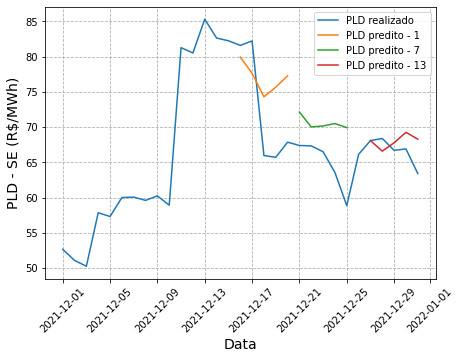

In [76]:
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_3_features['SE - PLD Médio (R$/MWh)']['2021-12-01':], label = 'PLD realizado')
plt.plot(testes_5[1]['df']['PLD - Predito'], label = 'PLD predito - 1')
plt.plot(testes_5[7]['df']['PLD - Predito'], label = 'PLD predito - 7')
plt.plot(testes_5[13]['df']['PLD - Predito'], label = 'PLD predito - 13')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Multi_step\Modelo_5',bbox_inches='tight')

In [77]:
indice = []
mae = []
for i in range (1,testX.shape[0]+1):
    indice.append(i)
    mae.append(testes_5[i]['info']['mae'])
df_mae = pd.DataFrame({'Teste':indice,'MAE':mae})
df_mae['MAE'].mean()

5.44826871166121

In [78]:
indice = []
mapes = []
for i in range (1,testX.shape[0]+1):
    indice.append(i)
    mapes.append(testes_5[i]['info']['mape'])
df_mape = pd.DataFrame({'Teste':indice,'MAPE':mapes})
df_mape['MAPE'].mean()

0.08256173234540072

In [79]:
indice = []
mapes = []
for i in range (1,testX.shape[0]+1):
    indice.append(i)
    mapes.append(testes_5[i]['info']['rmse'])
df_mape = pd.DataFrame({'Teste':indice,'RMSE':mapes})
count = 0
SE = 0
for j in df_mape['RMSE']:
    SE = j*j +SE
    count+=1
print(sqrt(SE/count))

6.6043284974345875


## Erro por passo

In [87]:
df_init_5 = testes_5[1]['df'].reset_index()
for i in range(2,len(testes_5)+1):
    df_init_5 =  df_init_5.append(testes_5[i]['df'].reset_index())


In [88]:
df_erros_passos_5 = pd.DataFrame()
df_erros_passos_5['PE Passo 1'] = df_init_5['PE'][0]
df_erros_passos_5['AE Passo 1'] = df_init_5['AE'][0]
df_erros_passos_5['SE Passo 1'] = df_init_5['SE'][0]
df_erros_passos_5 = df_erros_passos_5.reset_index().drop(columns=['index'])
for i in range(1,max(df_init_5.index)+1):
    df_erro = pd.DataFrame()
    df_erro['PE Passo ' + str(i+1)] = df_init_5['PE'][i]
    df_erro['AE Passo ' + str(i+1)] = df_init_5['AE'][i]
    df_erro['SE Passo ' + str(i+1)] = df_init_5['SE'][i]
    df_erro = df_erro.reset_index().drop(columns=['index'])
    df_erros_passos_5 = df_erros_passos_5.join(df_erro)
df_erros_passos_5

,PE Passo 1,AE Passo 1,SE Passo 1,PE Passo 2,AE Passo 2,SE Passo 2,PE Passo 3,AE Passo 3,SE Passo 3,PE Passo 4,AE Passo 4,SE Passo 4,PE Passo 5,AE Passo 5,SE Passo 5
0,0.037736,3.103841,9.633829,0.056761,4.631365,21.449542,0.110285,9.068798,82.243094,0.128627,8.485599,72.005398,0.163801,10.764974,115.884670
1,0.020227,1.650398,2.723814,0.055862,4.593613,21.101283,0.126198,8.325372,69.311827,0.151391,9.949421,98.990980,0.138811,9.420292,88.741904
2,0.026412,2.171882,4.717070,0.177614,11.717333,137.295898,0.139300,9.154790,83.810178,0.123071,8.352087,69.757352,0.148480,10.006680,100.133653
3,0.214107,14.124821,199.510562,0.182205,11.974536,143.389522,0.111202,7.546613,56.951374,0.138122,9.308586,86.649773,0.150592,10.139852,102.816608
4,0.166456,10.939490,119.672435,0.096056,6.518772,42.494386,0.084874,5.720036,32.718816,0.099391,6.692359,44.787675,0.115940,7.710827,59.456861
5,0.087927,5.967102,35.606311,0.063333,4.268242,18.217892,0.058085,3.911047,15.296287,0.079027,5.255824,27.623683,0.125106,7.951290,63.223015
6,0.070275,4.736135,22.430973,0.040033,2.695545,7.265961,0.054960,3.655196,13.360459,0.109393,6.952587,48.338468,0.188096,11.071488,122.577838
7,0.052803,3.555399,12.640860,0.034950,2.324417,5.402913,0.092296,5.865978,34.409695,0.184407,10.854330,117.816469,0.040847,2.701530,7.298267
8,0.054913,3.652135,13.338089,0.072907,4.633665,21.470851,0.172604,10.159613,103.217728,0.051809,3.426548,11.741228,0.005351,0.364286,0.132704
9,0.095397,6.063106,36.761253,0.151793,8.934683,79.828567,0.038581,2.551700,6.511170,0.022438,1.527696,2.333856,0.000506,0.034581,0.001196


In [89]:
indice=[]
mape=[]
mae=[]
rmse=[]
for i in range(1,max(df_init_5.index)+2):
    indice.append(i)
    mape.append(df_erros_passos_5['PE Passo '+str(i)].mean())
    mae.append(df_erros_passos_5['AE Passo '+str(i)].mean())
    rmse.append(sqrt(df_erros_passos_5['SE Passo '+str(i)].mean()))
df_erros_5 = pd.DataFrame({'Indice':indice, 'MAE - Multistep 5':mae, 'MAPE - Multistep 5':mape, 'RMSE - Multistep 5':rmse})
df_erros_5 = df_erros_5.set_index('Indice')
df_erros_5

,MAE - Multistep 5,MAPE - Multistep 5,RMSE - Multistep 5
Indice,,,
1,5.136026,0.077524,6.522170
2,5.180058,0.077377,6.249623
3,5.274697,0.078998,6.208279
4,5.790914,0.088801,6.725724
5,5.859647,0.090109,7.260248


________________________________________________________________________________________________________________________________________

# MultiStep - 7 passos à frente

In [90]:
iniciotrein, fimtrein, inicioteste, fimteste = '2018-02-05','2021-11-30','2021-12-01','2021-12-31'
df_treinamento = df_3_features.loc[iniciotrein:fimtrein]
df_teste = df_3_features.loc[inicioteste:fimteste]
df_teste_original = df_3_features.loc[inicioteste:fimteste]

df_for_training = df_treinamento
scaler = MinMaxScaler()
scaler_train = scaler.fit(df_for_training)
df_for_training_scaled = scaler_train.transform(df_for_training)
df_comp_trein = pd.DataFrame(df_for_training_scaled)
df_comp_trein = df_comp_trein.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_trein = df_comp_trein.set_index(df_treinamento.index)


In [91]:
df_for_testing = df_teste
df_for_testing_scaled = scaler_train.transform(df_for_testing)
df_comp_teste = pd.DataFrame(df_for_testing_scaled)
df_comp_teste = df_comp_teste.rename(columns={0:'SE - PLD Médio (R$/MWh)',1:'ENA Bruta (MWm)',2:'EAR Verif. (MWmês)'})
df_comp_teste = df_comp_teste.set_index(df_teste.index)


In [92]:
trainX = []
trainY = []
testX = []
testY = []
n_future = 7
n_past = 14

In [93]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i :i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [94]:
for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing_scaled.shape[1]])
    testY.append(df_for_testing_scaled[i :i + n_future, 0])
    
testX, testY = np.array(testX), np.array(testY)

In [95]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1289, 14, 3).
trainY shape == (1289, 7).
testX shape == (11, 14, 3).
testY shape == (11, 7).


In [99]:
model = load_model('Modelos_Multi_Step\model_lstm_multistep_nstep14_nforw7_.h5')

In [100]:
testes_7 = teste_modelo_3feat (model, trainX, trainY, testX, testY, scaler_train, df_teste_original)

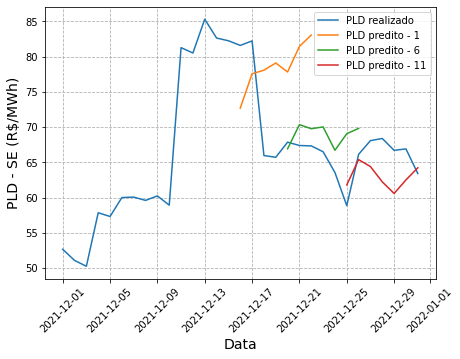

In [102]:
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_3_features['SE - PLD Médio (R$/MWh)']['2021-12-01':], label = 'PLD realizado')
plt.plot(testes_7[1]['df']['PLD - Predito'], label = 'PLD predito - 1')
plt.plot(testes_7[6]['df']['PLD - Predito'], label = 'PLD predito - 6')
plt.plot(testes_7[11]['df']['PLD - Predito'], label = 'PLD predito - 11')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Multi_step\Modelo_7',bbox_inches='tight')

In [103]:
indice = []
mae = []
for i in range (1,testX.shape[0]+1):
    indice.append(i)
    mae.append(testes_7[i]['info']['mae'])
df_mae = pd.DataFrame({'Teste':indice,'MAE':mae})
df_mae['MAE'].mean()

7.00382780281889

In [104]:
indice = []
mapes = []
for i in range (1,testX.shape[0]+1):
    indice.append(i)
    mapes.append(testes_7[i]['info']['mape'])
df_mape = pd.DataFrame({'Teste':indice,'MAPE':mapes})
df_mape['MAPE'].mean()

0.10476779357410461

In [105]:
indice = []
mapes = []
for i in range (1,testX.shape[0]+1):
    indice.append(i)
    mapes.append(testes_7[i]['info']['rmse'])
df_mape = pd.DataFrame({'Teste':indice,'RMSE':mapes})

count = 0
SE = 0
for j in df_mape['RMSE']:
    SE = j*j +SE
    count+=1

print(sqrt(SE/count))

8.403324044729105


## Erro por passo

In [132]:
df_init_7 = testes_7[1]['df'].reset_index()
for i in range(2,len(testes_7)+1):
    df_init_7 =  df_init_7.append(testes_7[i]['df'].reset_index())
df_init_7

,Data,PLD - Predito,SE - PLD Médio (R$/MWh),PE,AE,SE
0,2021-12-15,70.255899,82.251250,0.145838,11.995351,143.888447
1,2021-12-16,75.537110,81.594583,0.074239,6.057473,36.692980
2,2021-12-17,76.154590,82.230833,0.073893,6.076243,36.920727
3,2021-12-18,76.872695,65.970833,0.165253,10.901861,118.850578
4,2021-12-19,75.850246,65.720000,0.154143,10.130246,102.621876
...,...,...,...,...,...,...
2,2021-12-27,64.401975,68.084167,0.054083,3.682192,13.558538
3,2021-12-28,62.232320,68.389167,0.090027,6.156847,37.906764
4,2021-12-29,60.587371,66.705417,0.091717,6.118046,37.430483
5,2021-12-30,62.509977,66.911250,0.065778,4.401273,19.371204


In [133]:
df_erros_passos_7 = pd.DataFrame()
df_erros_passos_7['PE Passo 1'] = df_init_7['PE'][0]
df_erros_passos_7['AE Passo 1'] = df_init_7['AE'][0]
df_erros_passos_7['SE Passo 1'] = df_init_7['SE'][0]
df_erros_passos_7 = df_erros_passos_7.reset_index().drop(columns=['index'])
for i in range(1,max(df_init_7.index)+1):
    df_erro = pd.DataFrame()
    df_erro['PE Passo ' + str(i+1)] = df_init_7['PE'][i]
    df_erro['AE Passo ' + str(i+1)] = df_init_7['AE'][i]
    df_erro['SE Passo ' + str(i+1)] = df_init_7['SE'][i]
    df_erro = df_erro.reset_index().drop(columns=['index'])
    df_erros_passos_7 = df_erros_passos_7.join(df_erro)
df_erros_passos_7

,PE Passo 1,AE Passo 1,SE Passo 1,PE Passo 2,AE Passo 2,SE Passo 2,PE Passo 3,AE Passo 3,SE Passo 3,PE Passo 4,...,SE Passo 4,PE Passo 5,AE Passo 5,SE Passo 5,PE Passo 6,AE Passo 6,SE Passo 6,PE Passo 7,AE Passo 7,SE Passo 7
0,0.145838,11.995351,143.888447,0.074239,6.057473,36.692980,0.073893,6.076243,36.920727,0.165253,...,118.850578,0.154143,10.130246,102.621876,0.175103,11.883211,141.210694,0.209058,14.089279,198.507787
1,0.109125,8.903988,79.281006,0.056646,4.658017,21.697123,0.183492,12.105135,146.534285,0.203549,...,178.950795,0.146763,9.959968,99.200962,0.208655,14.062154,197.744165,0.233613,15.729911,247.430112
2,0.101016,8.306596,68.999530,0.188430,12.430864,154.526371,0.197891,13.005411,169.140711,0.176466,...,143.417897,0.160620,10.824824,117.176825,0.210212,14.154260,200.343087,0.247375,16.452172,270.673969
3,0.130102,8.582923,73.666564,0.197273,12.964787,168.085714,0.160775,10.910865,119.046970,0.184918,...,155.310652,0.156800,10.557877,111.468770,0.215460,14.329640,205.338590,0.292388,18.583106,345.331822
4,0.074541,4.898807,23.998309,0.095563,6.485293,42.059021,0.098575,6.643406,44.134846,0.111039,...,55.899527,0.084044,5.589520,31.242735,0.175940,11.182077,125.038849,0.286892,16.886676,285.159825
5,0.013826,0.938308,0.880422,0.043910,2.959256,8.757198,0.036215,2.438497,5.946268,0.052962,...,12.407150,0.049705,3.159086,9.979824,0.173422,10.207741,104.197978,0.055622,3.678717,13.532962
6,0.042793,2.884014,8.317539,0.006055,0.407719,0.166235,0.007565,0.503120,0.253129,0.050273,...,10.208892,0.075181,4.425243,19.582777,0.010593,0.700624,0.490874,0.028836,1.963285,3.854487
7,0.066318,4.465399,19.939788,0.007225,0.480502,0.230882,0.025797,1.639577,2.688214,0.094814,...,31.145981,0.076017,5.027607,25.276836,0.071918,4.896462,23.975336,0.064507,4.411580,19.462042
8,0.066337,4.411867,19.464570,0.027555,1.751295,3.067033,0.094276,5.549172,30.793304,0.044819,...,8.786663,0.115054,7.833363,61.361571,0.088805,6.073285,36.884790,0.050593,3.374847,11.389590
9,0.024596,1.563259,2.443779,0.110333,6.494292,42.175835,0.025443,1.682753,2.831659,0.078423,...,28.508824,0.116325,7.955377,63.288024,0.063074,4.207407,17.702273,0.046615,3.119096,9.728762


In [108]:
indice=[]
mape=[]
mae=[]
rmse=[]
for i in range(1,max(df_init_7.index)+2):
    indice.append(i)
    mape.append(df_erros_passos_7['PE Passo '+str(i)].mean())
    mae.append(df_erros_passos_7['AE Passo '+str(i)].mean())
    rmse.append(sqrt(df_erros_passos_7['SE Passo '+str(i)].mean()))
df_erros_7 = pd.DataFrame({'Indice':indice, 'MAE - Multistep':mae, 'MAPE - Multistep':mape, 'RMSE - Multistep':rmse})
df_erros_7 = df_erros_7.set_index('Indice')
df_erros_7

,MAE - Multistep,MAPE - Multistep,RMSE - Multistep
Indice,,,
1,5.444186,0.074942,6.392448
2,5.039527,0.074409,6.592102
3,5.839670,0.087091,7.210148
4,7.541147,0.113867,8.428273
5,7.416469,0.111488,7.854534
6,8.736194,0.132633,9.873278
7,9.009602,0.138944,11.304620


________________________________________________________________________________________________________________________________________

# Comparação Erros

## Naive

In [116]:
datainicio,datafim = '2021-12-01','2021-12-31'

df_naive = pd.DataFrame()
df_naive['Original'] = df_4_features_mediacarga['SE - PLD Médio (R$/MWh)'][datainicio:datafim ]
df_naive['Naive'] = df_naive.shift(periods=1)

In [117]:
n = 7
datainicio = '2021-12-15'

count = 0
pred_naive = {}
for i in df_naive[datainicio:].index[:len(df_naive[datainicio:].index)-n+1]:
    count+=1
    aux = pd.DataFrame({'Teste Naive' :[df_naive['Naive'][i]]*n})
    aux = aux.set_index(df_naive[i:].index[0:n])
    pred_naive[count] = aux

In [118]:
dict_comp = {}
count=0
for i in range(1,len(pred_naive)+1):
    count+=1
    df_comp = pd.DataFrame()
    df_comp['Original'] = df_naive['Original']
    df_comp = df_comp.join(pred_naive[i]).dropna()
    dict_comp[count]=df_comp

In [119]:
dict_global = {}
for i in range(1,len(dict_comp)+1):
    aval = avaliacao(dict_comp[i], 'Teste Naive', 'Original')
    dict_info = {'mae':aval[0], 'mape':aval[1], 'rmse':aval[2]}
    dict_append = {'df':aval[3], 'info':dict_info }
    dict_global[i] = dict_append

In [120]:
df_init = dict_global[1]['df'].reset_index()
for i in range(2,len(dict_global)+1):
    df_init =  df_init.append(dict_global[i]['df'].reset_index())

In [121]:
df_erros_passos = pd.DataFrame()
df_erros_passos['PE Passo 1'] = df_init['PE'][0]
df_erros_passos['AE Passo 1'] = df_init['AE'][0]
df_erros_passos['SE Passo 1'] = df_init['SE'][0]
df_erros_passos = df_erros_passos.reset_index().drop(columns=['index'])
for i in range(1,max(df_init.index)+1):
    df_erro = pd.DataFrame()
    df_erro['PE Passo ' + str(i+1)] = df_init['PE'][i]
    df_erro['AE Passo ' + str(i+1)] = df_init['AE'][i]
    df_erro['SE Passo ' + str(i+1)] = df_init['SE'][i]
    df_erro = df_erro.reset_index().drop(columns=['index'])
    df_erros_passos = df_erros_passos.join(df_erro)

In [122]:
indice=[]
mape=[]
mae=[]
rmse=[]
for i in range(1,max(df_init.index)+2):
    indice.append(i)
    mape.append(df_erros_passos['PE Passo '+str(i)].mean())
    mae.append(df_erros_passos['AE Passo '+str(i)].mean())
    rmse.append(sqrt(df_erros_passos['SE Passo '+str(i)].mean()))
df_erros_naive = pd.DataFrame({'Indice':indice, 'MAE - Naive':mae, 'MAPE - Naive':mape, 'RMSE - Naive':rmse})
df_erros_naive = df_erros_naive.set_index('Indice')
df_erros_naive

,MAE - Naive,MAPE - Naive,RMSE - Naive
Indice,,,
1,3.463542,0.047927,6.808089
2,5.827014,0.080833,9.260861
3,8.045764,0.109844,11.628664
4,10.022130,0.135966,13.271064
5,10.688657,0.146057,13.984378
6,11.331157,0.155328,14.377215
7,11.736782,0.163266,14.648493


## Comparação

In [123]:
df_erros_single7 =  pd.read_excel('erro_passos_single_step.xlsx', index_col='Indice')
df_erros_single7 

,MAE - Singlestep,MAPE - Singlestep,RMSE - Singlestep
Indice,,,
1,4.433091,0.062109,6.807031
2,6.841703,0.091865,9.993619
3,9.223188,0.130602,10.933066
4,9.497484,0.128730,10.762966
5,10.312060,0.135238,13.426104
6,10.975336,0.145687,13.799647
7,10.766254,0.151875,12.425620


In [124]:
df_comp_erros = df_erros_naive.join(df_erros_7).join(df_erros_single7).join(df_erros_5).join(df_erros_3)
df_comp_erros = df_comp_erros.rename(columns={'MAPE - Multistep':'MAPE - Multistep 7'})

C:\Users\pablo\AppData\Local\Temp/ipykernel_31748/3000892796.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


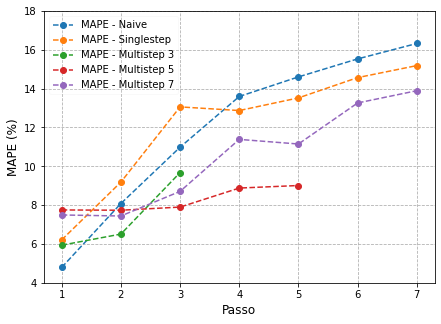

In [125]:
fig = plt.figure(figsize=(7, 5))

for column in ['MAPE - Naive', 'MAPE - Singlestep', 'MAPE - Multistep 3', 'MAPE - Multistep 5', 'MAPE - Multistep 7']:
    plt.plot(df_comp_erros[column]*100, linestyle='--', marker='o', label=column)
      
    
plt.xlabel('Passo', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.grid(linestyle='--')
#plt.title('Erro em função do passo para diferentes métodos', fontsize=14)

plt.legend(fancybox=True, framealpha=0.1) # O framealpha altera a transparencia da caixa de legenda
plt.ylim((4,18)) # LIMITES DO EIXO Y

fig.show()
#fig.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\ComparacaoErros',bbox_inches='tight')